In [1]:
%matplotlib notebook

Watching the animals it seems obvious that they modulate their speed when the red light is turned on. 

Similar to larval speed, the x and y coordinates are first filtered using a triangular rolling window. The window size is:

$$Window Size = \frac{fps}{(MovementSpeed * PixelPerMm}$$

Identical to speed of larvae, the speed itself is again filtered using a triangular rolling filter with window size 1 second (30frames).

Sorting each timepoint whether an animal is in the light on or off square is straightforward as we know exactly what the stimulation was at each timepoint.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
import json
from scipy.spatial import distance
from scipy import stats
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator
from pathlib import Path
import scikit_posthocs as sp
import statsmodels.api as sm

In [3]:
home_path = os.getcwd()
data_path = Path(home_path, 'data/Gr66a-Gal4xUAS-Chrimson/')
data_path_ctr = Path(home_path, 'data/empty-Gal4xUAS-Chrimson/')
# all the figures will be saved in this folder
target_path = Path(home_path, 'plots/')
Path(target_path).mkdir(parents=True, exist_ok=True) 

In [4]:
def signal_filter(x_data, y_data, win_size, filter_name, pxmm, fps):
        if filter_name == 'Savitzky-Golay':
            x = savgol_filter(x_data.dropna(), win_size, 2)
            y = savgol_filter(y_data.dropna(), win_size, 2)
        else:
            x = x_data.rolling(window=win_size, win_type=filter_name).mean()
            y = y_data.rolling(window=win_size, win_type=filter_name).mean()


        speed = np.zeros(x_data.shape[0])
        dist = np.zeros(x_data.shape[0])
        for i in range(1, speed.shape[0]):
            try:
                # ((px/frames) / (px/mm)) * frames/second = mm/second
                dist[i]  = np.linalg.norm(np.array(x[i], y[i]))
                speed[i] = (np.linalg.norm(np.array(x[i], y[i]) - np.array(x[i-1], y[i-1])) / pxmm) * fps
            except IndexError:
                pass
        return(speed)


In [5]:
# Collect experimental data 
folders_Gr66a = [x for x in data_path.iterdir() if x.is_dir()]

speed_Gr66a_ON = []
speed_Gr66a_OFF = []
speed_modulation_Gr66a = []

for i, folder_name in enumerate(folders_Gr66a):
    print('Analyzing ' + folder_name.parts[-1])
    
    files = [x for x in folder_name.iterdir() if x.is_file()]
    # find the data_file.csv to get the distance to source of the centroid
    for file in files:
        if 'data.csv' in file.parts[-1]:
            data = pd.read_csv(file)
            
    if i == 0:
        speed_centroid_Gr66a = pd.DataFrame()
        filtered_speed_centroid_Gr66a = pd.DataFrame() 
        stimulation_Gr66a = pd.DataFrame()
        filtered_speed_Gr66a_np = np.zeros((data.shape[0], len(folders_Gr66a)))
        
    with open(Path(str(folder_name), 'experiment_settings.json'), 'r') as file:
        experiment_settings = json.load(file)
    fps = experiment_settings['Framerate']
    pixel_per_mm = experiment_settings['Pixel per mm']
    # how fast does the animal move?
    mm_per_second = 5
    # window size should always be odd as to not shift the value
    if int(fps/(mm_per_second*pixel_per_mm)) % 2 == 0:
        # even
        final_window_size = int((fps/(mm_per_second*pixel_per_mm)) + 1)
    else:
        # odd
        final_window_size = int(fps/(mm_per_second*pixel_per_mm))

    # first filter: filter on x/y coordinates-can actually skip this as window length is one
    speed_centroid_Gr66a[folders_Gr66a[i]] = signal_filter(data['X-Centroid'], 
                                                           data['Y-Centroid'], 
                                                           final_window_size, 
                                                           'triang', 
                                                           pixel_per_mm, fps)[:]
    # second filter: filter speed, also drop all the NaNs! These interfere with the plotting later on
    filtered_speed_centroid_Gr66a[folders_Gr66a[i]]= \
                    speed_centroid_Gr66a[folders_Gr66a[i]].rolling(window=fps, 
                                                                   win_type='triang').mean().dropna()
    
    filtered_speed_Gr66a_np[0:filtered_speed_centroid_Gr66a[folders_Gr66a[i]].shape[0],i] = \
        filtered_speed_centroid_Gr66a[folders_Gr66a[i]]
    
    speed_Gr66a_ON.append(filtered_speed_centroid_Gr66a[folders_Gr66a[i]][data['stimulation'] < 40000])
    speed_Gr66a_OFF.append(filtered_speed_centroid_Gr66a[folders_Gr66a[i]][data['stimulation'] == 40000])
    
    speed_modulation_Gr66a.append(np.nanmedian(speed_Gr66a_OFF[i] / np.nanmedian(speed_Gr66a_ON[i])))
    
    stimulation_Gr66a[folders_Gr66a[i]] = data['stimulation']

Analyzing 04.10.2018_16-24-49_Gr66a-Gal4xUAS-Chrimson
Analyzing 04.10.2018_16-37-40_GR66a-Gal4xUAS-Chrimson
Analyzing 04.10.2018_16-49-15_GR66a-Gal4xUAS-Chrimson
Analyzing 04.10.2018_16-55-45_GR66a-Gal4xUAS-Chrimson
Analyzing 04.10.2018_17-01-14_GR66a-Gal4xUAS-Chrimson
Analyzing 04.10.2018_17-06-46_GR66a-Gal4xUAS-Chrimson
Analyzing 04.10.2018_17-17-45_GR66a-Gal4xUAS-Chrimson
Analyzing 04.10.2018_17-27-23_GR66a-Gal4xUAS-Chrimson
Analyzing 04.10.2018_17-37-11_GR66a-Gal4xUAS-Chrimson
Analyzing 04.10.2018_17-45-34_GR66a-Gal4xUAS-Chrimson
Analyzing 04.10.2018_17-51-10_GR66a-Gal4xUAS-Chrimson
Analyzing 05.10.2018_13-12-31_GR66a-Gal4xUAS-Chrimson
Analyzing 05.10.2018_13-29-42_GR66a-Gal4xUAS-Chrimson
Analyzing 05.10.2018_13-38-38_GR66a-Gal4xUAS-Chrimson
Analyzing 05.10.2018_13-57-46_GR66a-Gal4xUAS-Chrimson
Analyzing 05.10.2018_14-04-53_GR66a-Gal4xUAS-Chrimson
Analyzing 05.10.2018_14-10-45_GR66a-Gal4xUAS-Chrimson
Analyzing 05.10.2018_14-16-15_GR66a-Gal4xUAS-Chrimson
Analyzing 05.10.2018_14-25-5

In [6]:
# Collect the empty-Gal4 (control) data
folders_empty = [x for x in data_path_ctr.iterdir() if x.is_dir()]

speed_empty_ON = []
speed_empty_OFF = []
speed_modulation_empty = []

for i, folder_name in enumerate(folders_empty):
    print('Analyzing ' + folder_name.parts[-1])
    
    files = [x for x in folder_name.iterdir() if x.is_file()]
    # find the data_file.csv to get the distance to source of the centroid
    for file in files:
        if 'data.csv' in  file.parts[-1]:
            data = pd.read_csv(file)
            
    if i == 0:
        speed_centroid_empty = pd.DataFrame()
        filtered_speed_centroid_empty = pd.DataFrame() 
        stimulation_empty = pd.DataFrame()
        filtered_speed_empty_np = np.zeros((data.shape[0], len(folders_empty)))

    with open(Path(str(folder_name), 'experiment_settings.json'), 'r') as file:
        experiment_settings = json.load(file)
    fps = experiment_settings['Framerate']
    pixel_per_mm = experiment_settings['Pixel per mm']
    # how fast does the animal move?
    mm_per_second = 5
    # window size should always be odd as to not shift the value
    if int(fps/(mm_per_second*pixel_per_mm)) % 2 == 0:
        # even
        final_window_size = int((fps/(mm_per_second*pixel_per_mm)) + 1)
    else:
        # odd
        final_window_size = int(fps/(mm_per_second*pixel_per_mm))


    # first filter: filter on x/y coordinates-can actually skip this as window length is one
    speed_centroid_empty[folders_empty[i]] = signal_filter(data['X-Centroid'], 
                                                           data['Y-Centroid'], 
                                                           final_window_size, 
                                                           'triang', 
                                                           pixel_per_mm, fps)[:]
    # second filter: filter speed 
    filtered_speed_centroid_empty[folders_empty[i]] = \
        speed_centroid_empty[folders_empty[i]].rolling(window=fps, 
                                                       win_type='triang').mean().dropna()
    
    filtered_speed_empty_np[0:filtered_speed_centroid_empty[folders_empty[i]].shape[0],i] = \
        filtered_speed_centroid_empty[folders_empty[i]]
    
    speed_empty_ON.append(filtered_speed_centroid_empty[folders_empty[i]][data['stimulation'] < 40000])
    speed_empty_OFF.append(filtered_speed_centroid_empty[folders_empty[i]][data['stimulation'] == 40000])
    
    speed_modulation_empty.append(np.nanmedian(speed_empty_OFF[i] / np.nanmedian(speed_empty_ON[i])))
    
    stimulation_empty[folders_empty[i]] = data['stimulation']
 

Analyzing 04.10.2018_14-20-29_empty-Gal4xUAS-Chrimson
Analyzing 04.10.2018_14-30-14_empty-Gal4xUAS-Chrimson
Analyzing 04.10.2018_14-50-03_empty-Gal4xUAS-Chrimson
Analyzing 04.10.2018_14-55-36_empty-Gal4xUAS-Chrimson
Analyzing 04.10.2018_15-03-24_empty-Gal4xUAS-Chrimson
Analyzing 04.10.2018_15-10-31_empty-Gal4xUAS-Chrimson
Analyzing 04.10.2018_15-17-57_empty-Gal4xUAS-Chrimson
Analyzing 04.10.2018_15-30-41_empty-Gal4xUAS-Chrimson
Analyzing 04.10.2018_15-36-18_empty-Gal4xUAS-Chrimson
Analyzing 04.10.2018_15-54-05_empty-Gal4xUAS-Chrimson
Analyzing 05.10.2018_15-52-29_empty-Gal4xUAS-Chrimson
Analyzing 05.10.2018_15-58-02_empty-Gal4xUAS-Chrimson
Analyzing 05.10.2018_16-03-29_empty-Gal4xUAS-Chrimson
Analyzing 05.10.2018_16-08-58_empty-Gal4xUAS-Chrimson
Analyzing 05.10.2018_16-26-47_empty-Gal4xUAS-Chrimson
Analyzing 05.10.2018_16-32-26_empty-Gal4xUAS-Chrimson
Analyzing 05.10.2018_16-37-58_empty-Gal4xUAS-Chrimson
Analyzing 05.10.2018_16-43-20_empty-Gal4xUAS-Chrimson


C:\Users\David Tadres\.conda\envs\pivr_publication\lib\site-packages\numpy\lib\nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Analyzing 05.10.2018_16-48-47_empty-Gal4xUAS-Chrimson
Analyzing 05.10.2018_16-54-11_empty-Gal4xUAS-Chrimson
Analyzing 05.10.2018_16-59-27_empty-Gal4xUAS-Chrimson
Analyzing 05.10.2018_15-35-22_empty-Gal4xUAS-Chrimson
Analyzing 05.10.2018_15-40-54_empty-Gal4xUAS-Chrimson
Analyzing 05.10.2018_15-46-57_empty-Gal4xUAS-Chrimson


<IPython.core.display.Javascript object>


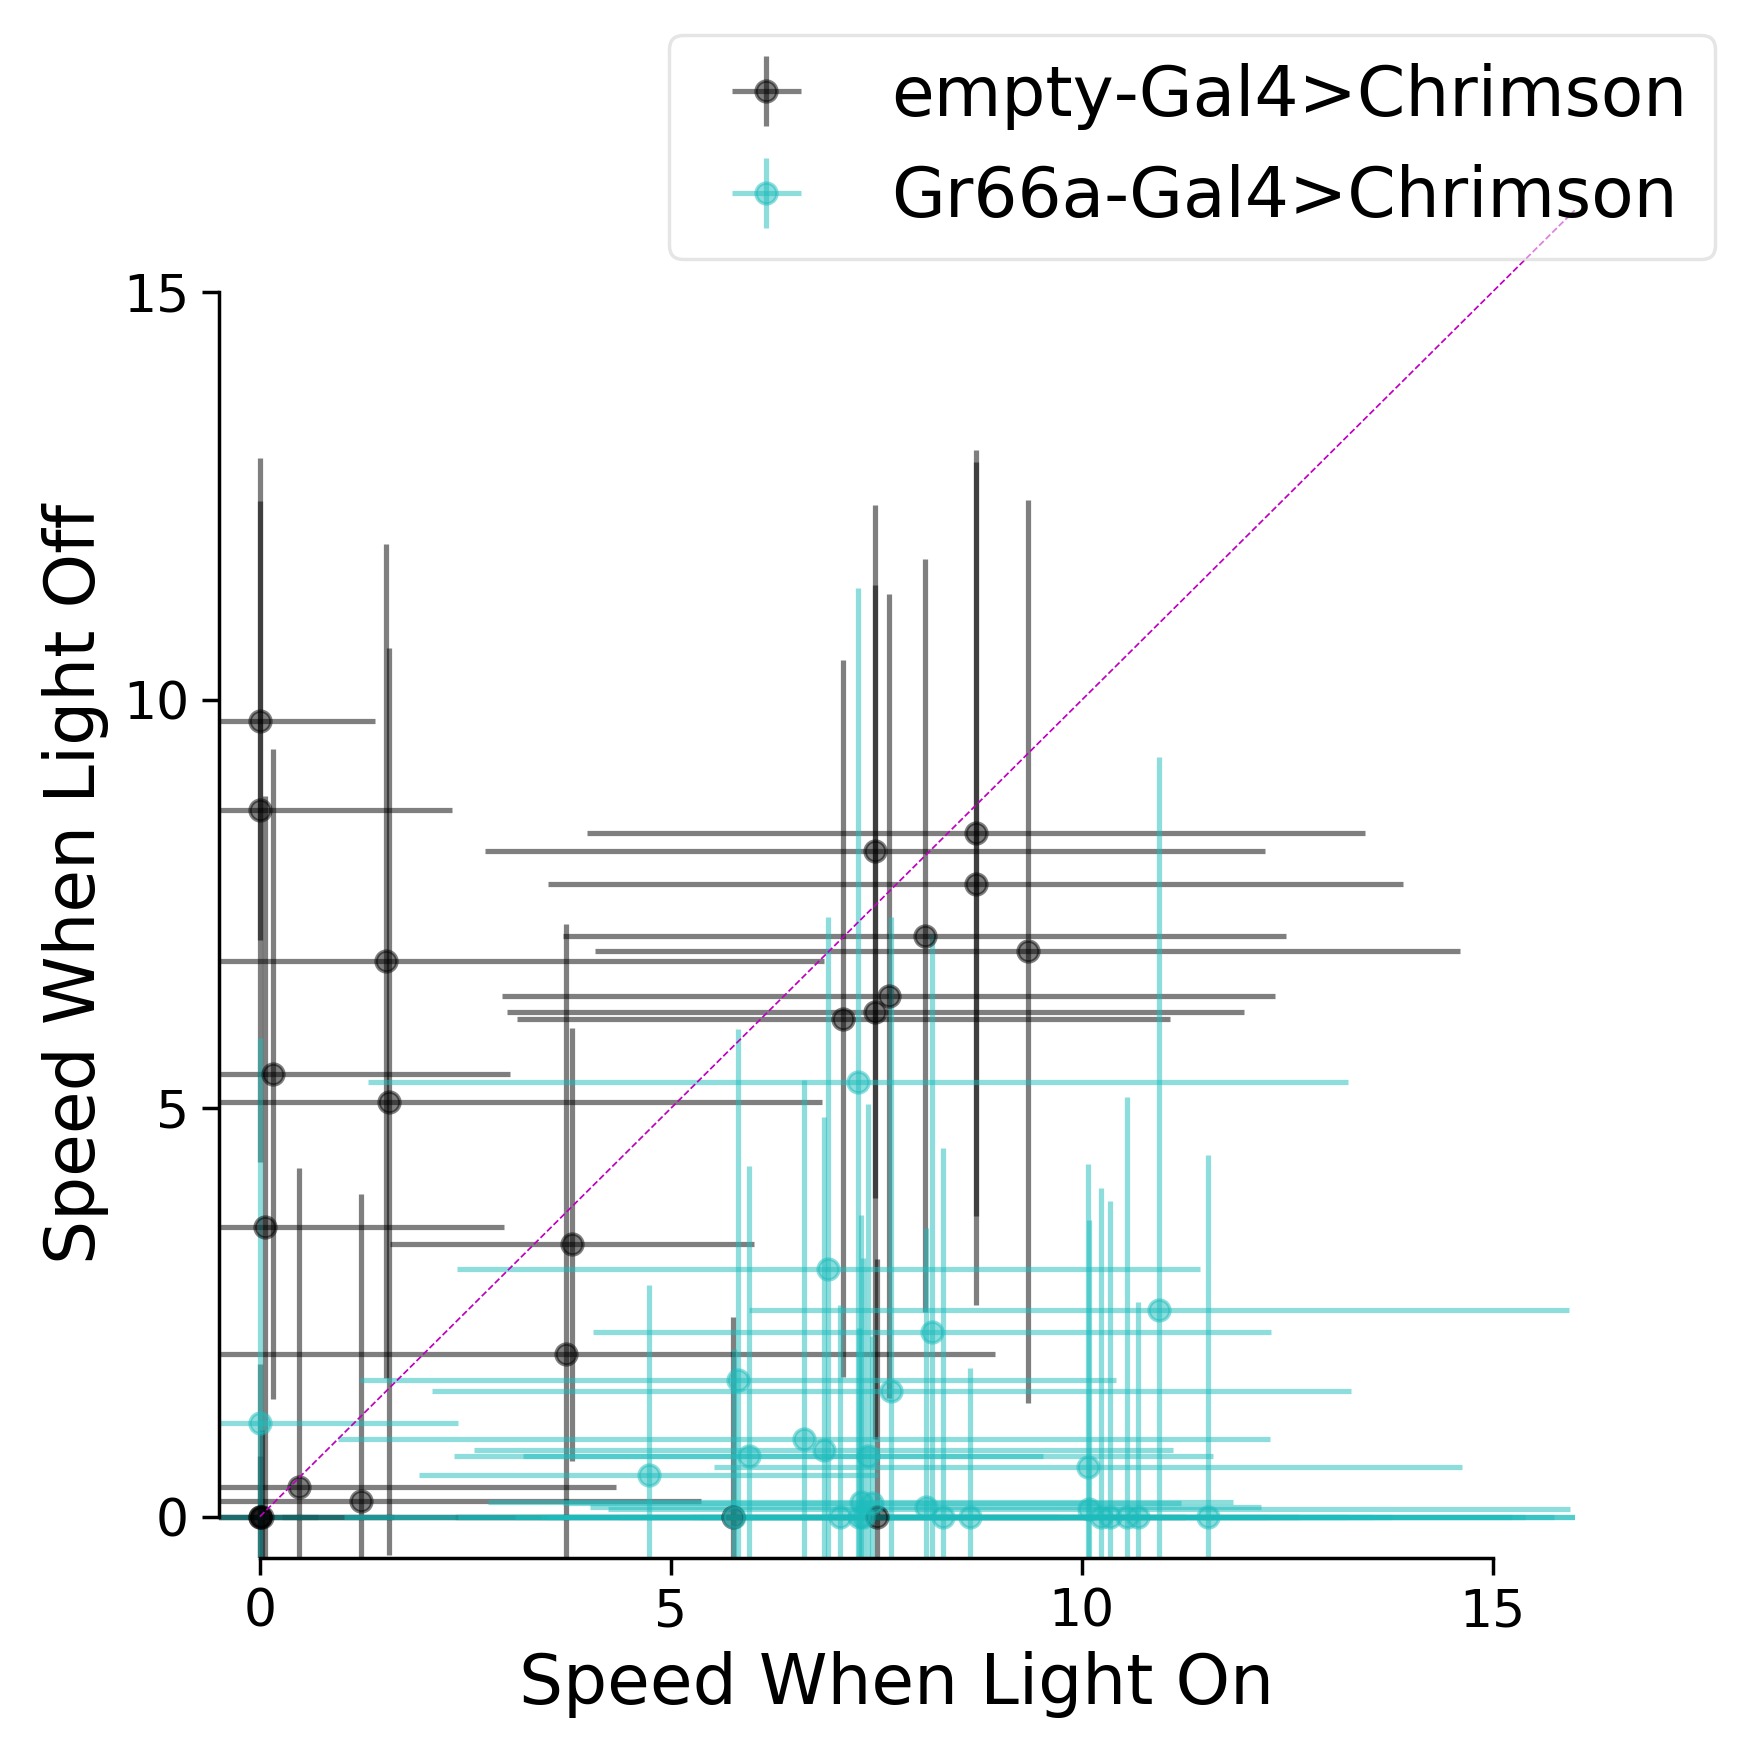

C:\Users\David Tadres\.conda\envs\pivr_publication\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [7]:
# It was suggested to plot speed light on on x and speed light off on v. Each point is the median of the speed
# and also indicate STD
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.set_rasterization_zorder(1)

speed_empty_ON_median = np.zeros((len(speed_empty_ON)))
speed_empty_OFF_median = np.zeros((len(speed_empty_OFF)))

speed_Gr66a_ON_median = np.zeros((len(speed_Gr66a_ON)))
speed_Gr66a_OFF_median = np.zeros((len(speed_Gr66a_OFF)))

for i in range(len(speed_empty_ON)):
    x = np.nanmedian(speed_empty_ON[i])
    y = np.nanmedian(speed_empty_OFF[i])

    if i == 0:
         ax.errorbar(x=np.nanmedian(speed_empty_ON[i]),
              y=np.nanmedian(speed_empty_OFF[i]), 
                xerr=np.nanstd(speed_empty_ON[i]),
                yerr=np.nanstd(speed_empty_OFF[i]),
                label='empty-Gal4>Chrimson',
                c='k', 
                fmt='o',
                alpha=0.5,
                zorder=0)       
    else:
        
        ax.errorbar(x=np.nanmedian(speed_empty_ON[i]),
              y=np.nanmedian(speed_empty_OFF[i]), 
                xerr=np.nanstd(speed_empty_ON[i]),
                yerr=np.nanstd(speed_empty_OFF[i]),
                c='k', fmt='o',alpha=0.5,zorder=0)
    if np.isnan(np.nanmedian(speed_empty_ON[i])) or np.isnan(np.nanmedian(speed_empty_OFF[i])):
        pass
    else:

        speed_empty_ON_median[i] = np.nanmedian(speed_empty_ON[i])
        speed_empty_OFF_median[i] = np.nanmedian(speed_empty_OFF[i])
        
#slope, intercept, r_value, p_value, std_err = stats.linregress(speed_empty_ON_median,speed_empty_OFF_median)
#ax.plot(np.array(speed_empty_ON_median), 
#        intercept + slope*np.array(speed_empty_ON_median), c='k', label='empty', zorder=1)
        
for i in range(len(speed_Gr66a_ON)):
    x = np.nanmedian(speed_Gr66a_ON[i])
    y = np.nanmedian(speed_Gr66a_OFF[i])

    if i == 0:
        ax.errorbar(x=np.nanmedian(speed_Gr66a_ON[i]),
                    y=np.nanmedian(speed_Gr66a_OFF[i]), 
                    xerr=np.nanstd(speed_Gr66a_ON[i]),
                    yerr=np.nanstd(speed_Gr66a_OFF[i]),
                    label='Gr66a-Gal4>Chrimson',
                    c='#1ebcbd',fmt='o', alpha=0.5,zorder=0)
    else:
        ax.errorbar(x=np.nanmedian(speed_Gr66a_ON[i]),
                    y=np.nanmedian(speed_Gr66a_OFF[i]), 
                    xerr=np.nanstd(speed_Gr66a_ON[i]),
                    yerr=np.nanstd(speed_Gr66a_OFF[i]),
                    c='#1ebcbd',fmt='o', alpha=0.5,zorder=0)
        
    if np.isnan(np.nanmedian(speed_Gr66a_ON[i])) or np.isnan(np.nanmedian(speed_Gr66a_OFF[i])):
        pass
    else:      
        speed_Gr66a_ON_median[i] = np.nanmedian(speed_Gr66a_ON[i])
        speed_Gr66a_OFF_median[i] = np.nanmedian(speed_Gr66a_OFF[i])
        
#slope, intercept, r_value, p_value, std_err = stats.linregress(speed_Gr66a_ON_median,speed_Gr66a_OFF_median)
#ax.plot(np.array(speed_Gr66a_ON_median), 
#        intercept + slope*np.array(speed_Gr66a_ON_median), c='r', label='gr66a', zorder=1)
    
ax.plot([0,20],[0,20], c='m',ls='--', lw=0.5)
ax.set_ylim(-0.5,16)
ax.set_xlim(-0.5,16)

ax.set_xticks([0,5,10,15])
ax.set_yticks([0,5,10,15])

# PLOT SPINES
# Only draw spine between the y-ticks
ax.spines['left'].set_bounds(0, 15)
ax.spines['bottom'].set_bounds(0, 15)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', width=1, length =5)
#ax.tick_params(axis='both', which='minor', width =2,length =3)

ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
#ax.xaxis.set_major_locator(MaxNLocator(nbins=5,integer=True))
#ax.yaxis.set_major_locator(MaxNLocator(nbins=5,integer=True))

ax.set_ylabel('Speed When Light Off', fontsize=20, zorder = 1)
ax.set_xlabel('Speed When Light On', fontsize=20, zorder = 1)

ax.set_xticks([0,5,10,15])
ax.set_yticks([0,5,10,15])

fig.legend(fontsize=20, framealpha=0.5)
# UNCOMMENT TO SAVE IMAGE (Takes a while)
#fig.savefig(Path(str(target_path),'Fig3e.eps'))#, rasterized=True, dpi=300)

<IPython.core.display.Javascript object>


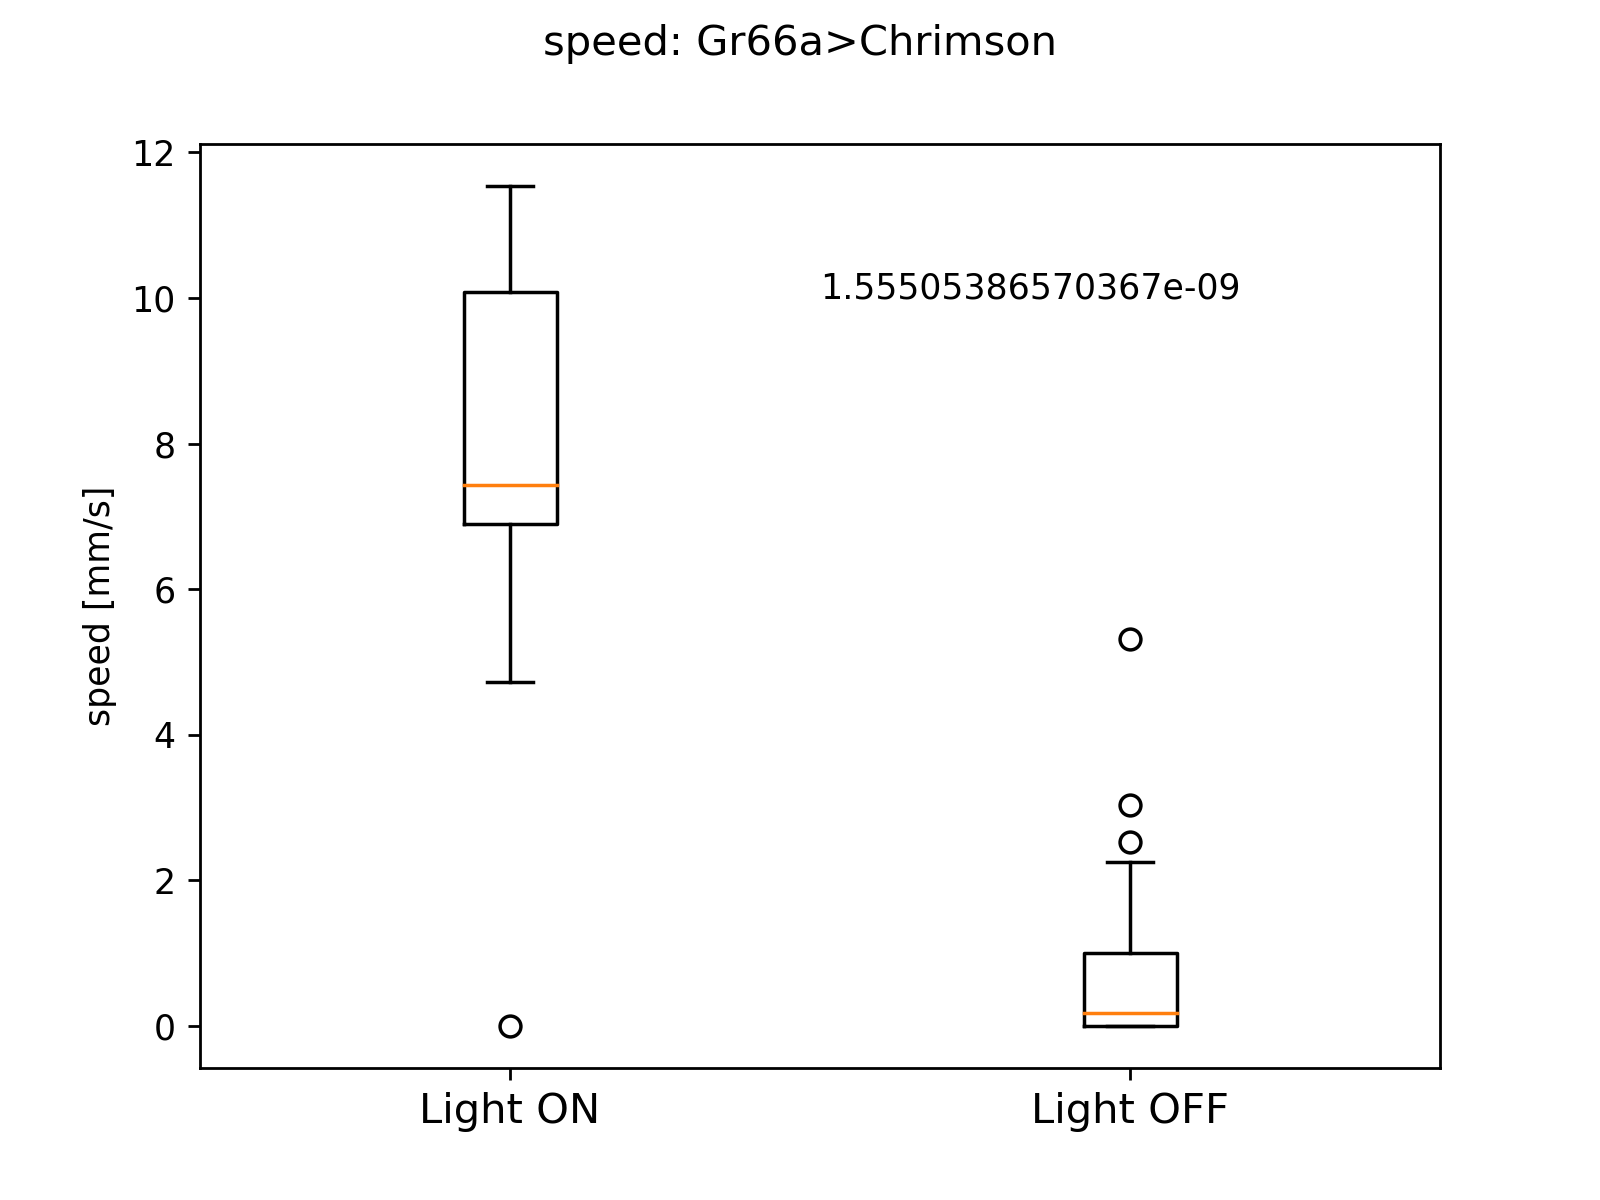


lilliefors Gr66a ON: 0.2 lilliefors Gr66a OFF: 5.0065087282761486e-05
LeveneResult(statistic=5.25517406869625, pvalue=0.025804508766185247)


Text(1.5, 10, '1.55505386570367e-09')

In [9]:
# compare median speed between in Gr66a between light ON vs OFF
Gr66a_ON_median = []
for i in range(len(speed_Gr66a_ON)):
    Gr66a_ON_median.append(speed_Gr66a_ON[i].median())
Gr66a_OFF_median = []
for i in range(len(speed_Gr66a_OFF)):
    Gr66a_OFF_median.append(speed_Gr66a_OFF[i].median())

data = [Gr66a_ON_median, Gr66a_OFF_median]
fig=plt.figure()
ax=fig.add_subplot(111)
ax.boxplot(data)
ax.set_xticklabels(['Light ON','Light OFF'], fontsize=12, rotation=0)
ax.set_ylabel('speed [mm/s]')
fig.suptitle('speed: Gr66a>Chrimson')
print("\nlilliefors Gr66a ON: " + repr(sm.stats.lilliefors(Gr66a_ON_median)[1]), 
     "lilliefors Gr66a OFF: " + repr(sm.stats.lilliefors(Gr66a_OFF_median)[1])) 
#The Levene test tests the null hypothesis that all input samples are from populations with equal variances. 
print(stats.levene(Gr66a_ON_median, Gr66a_OFF_median)) 
# As Levene's and Lilliefors test rejects the null hypothesis that the two samples have the same variance, 
# I have to use a non-parametric test: The Wilcoxon Rank Sum test (Mann-Whitney U)
ranksum_test_statistics = stats.ranksums(Gr66a_ON_median, Gr66a_OFF_median)
ax.text(1.5,10, ranksum_test_statistics[1])

<IPython.core.display.Javascript object>


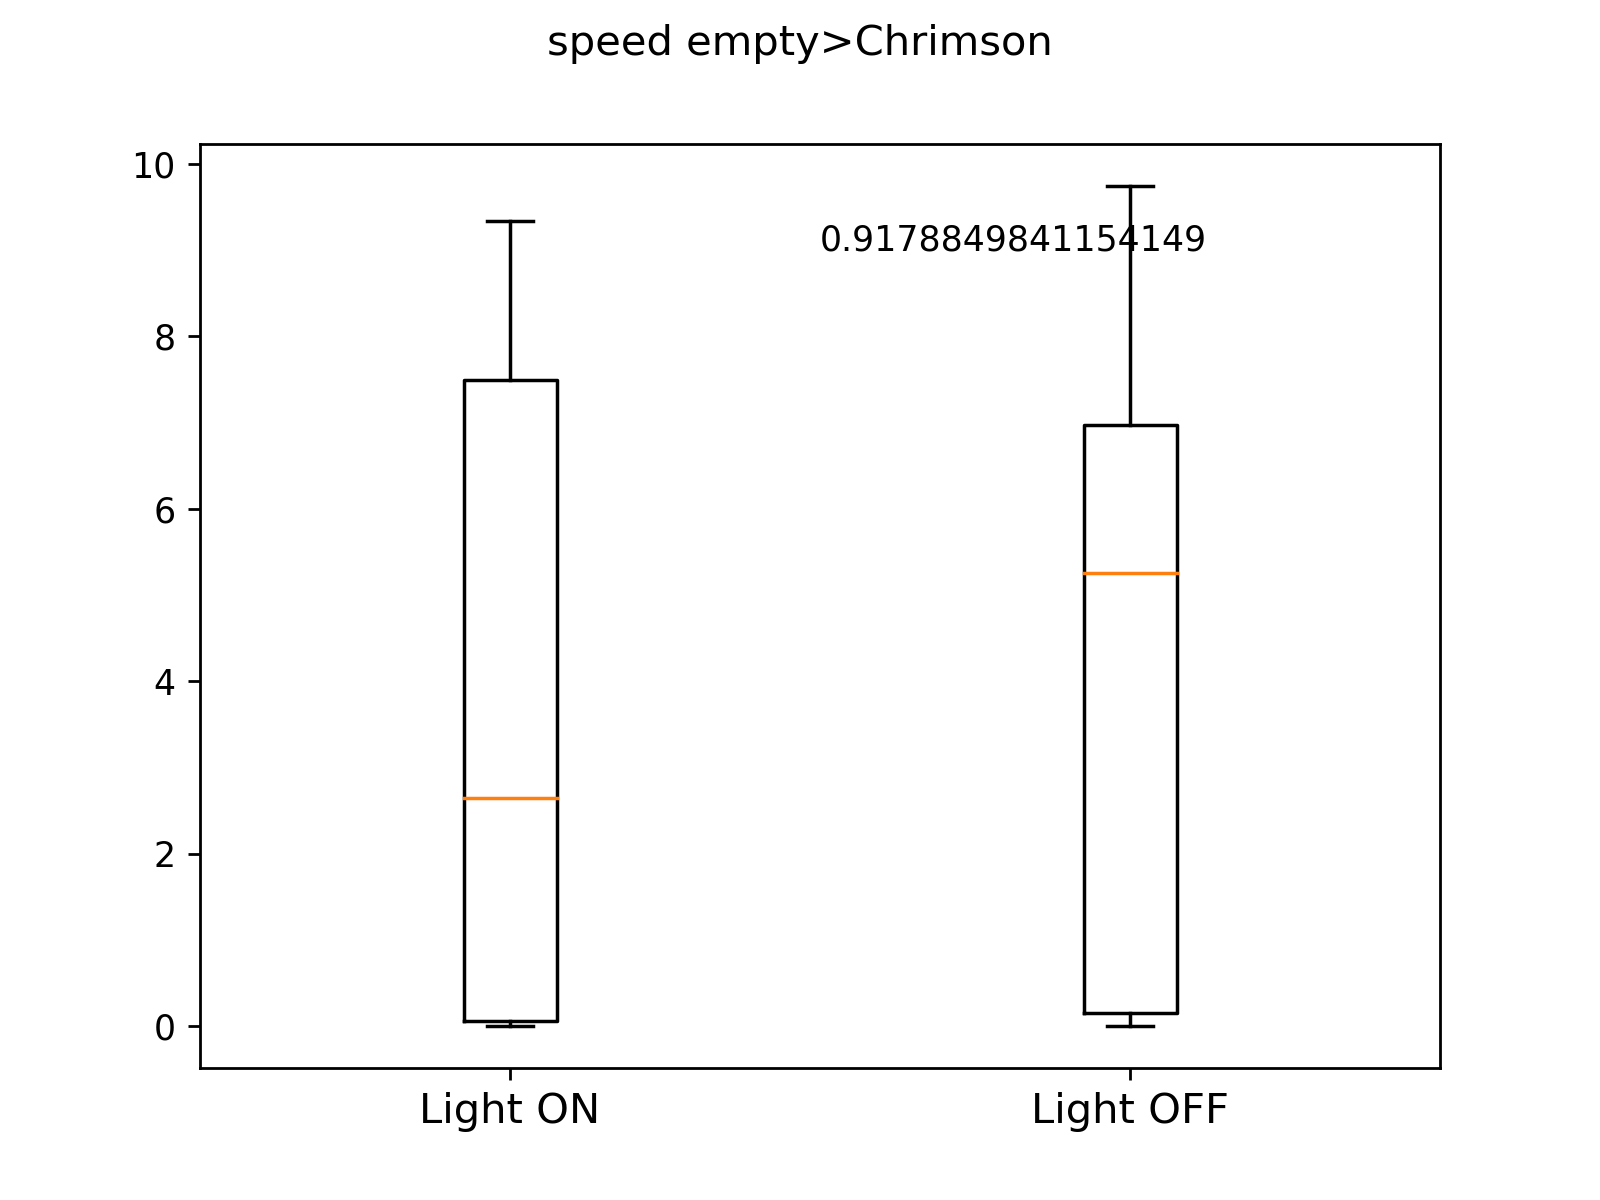


lilliefors empty ON: 0.0026942501439112007 lilliefors empty OFF: 0.011827582448204532
LeveneResult(statistic=0.3371999174718666, pvalue=0.5642841869340218)


Text(1.5, 9, '0.9178849841154149')

In [11]:
# compare median speed in empty-Galr between light ON vs OFF
empty_ON_median = []
for i in range(len(speed_empty_ON)):
    empty_ON_median.append(speed_empty_ON[i].median())
empty_OFF_median = []
for i in range(len(speed_empty_OFF)):
    if ~np.isnan(speed_empty_OFF[i].median()):
        empty_OFF_median.append(speed_empty_OFF[i].median())
    else: # there is one experiment where the animal never left the light - returns NaN and doesn't let me plot
        empty_OFF_median.append(0)

data = [empty_ON_median, empty_OFF_median]
fig=plt.figure()
ax=fig.add_subplot(111)
ax.boxplot(data)
ax.set_xticklabels(['Light ON','Light OFF'], fontsize=12, rotation=0)
fig.suptitle('speed empty>Chrimson')
print("\nlilliefors empty ON: " + repr(sm.stats.lilliefors(empty_ON_median)[1]), 
     "lilliefors empty OFF: " + repr(sm.stats.lilliefors(empty_OFF_median)[1])) 
#The Levene test tests the null hypothesis that all input samples are from populations with equal variances. 
print(stats.levene(empty_ON_median, empty_OFF_median)) 
# As Lilliefors test rejects assumption of normality, must use non-parametric test
ttest_statistics = stats.ranksums(empty_ON_median, empty_OFF_median)
ax.text(1.5,9, ttest_statistics[1])

<IPython.core.display.Javascript object>


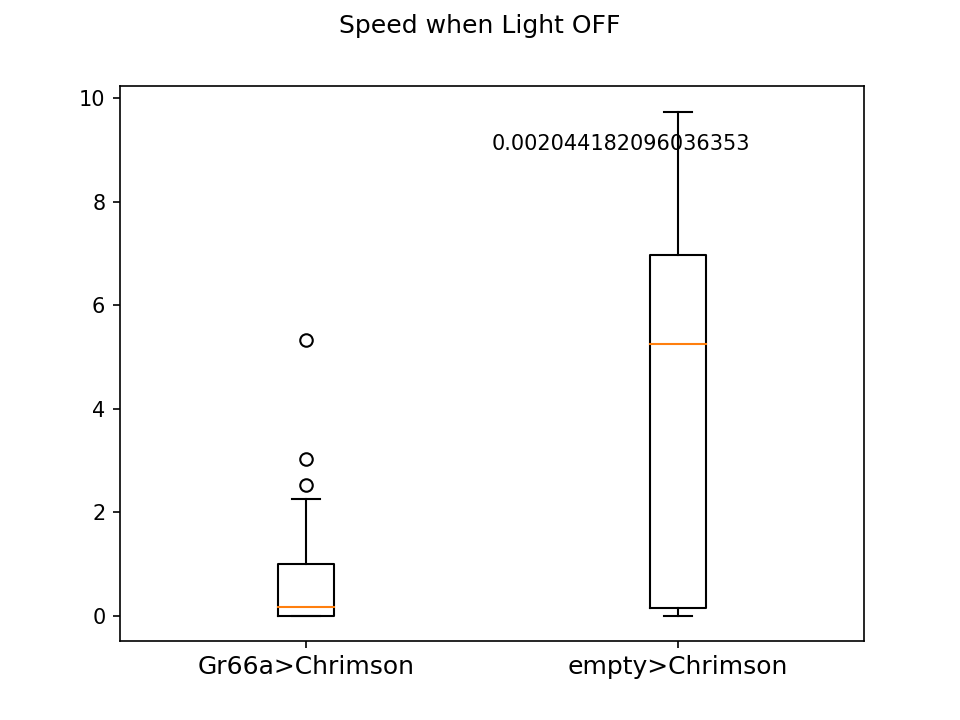

LeveneResult(statistic=29.589638601379853, pvalue=1.602606104933471e-06)


Text(1.5, 9, '0.002044182096036353')

In [10]:
# compare median speed between both genotypes when light is OFF
Gr66a_OFF_median = []
for i in range(len(speed_Gr66a_OFF)):
    Gr66a_OFF_median.append(speed_Gr66a_OFF[i].median())
empty_OFF_median = []
for i in range(len(speed_empty_OFF)):
    if ~np.isnan(speed_empty_OFF[i].median()):
        empty_OFF_median.append(speed_empty_OFF[i].median())
    else: # there is one experiment where the animal never left the light - returns NaN and doesn't let me plot
        empty_OFF_median.append(0)

data = [Gr66a_OFF_median, empty_OFF_median]
fig=plt.figure()
ax=fig.add_subplot(111)
ax.boxplot(data)
ax.set_xticklabels(['Gr66a>Chrimson','empty>Chrimson'], fontsize=12, rotation=0)
fig.suptitle('Speed when Light OFF')
#The Levene test tests the null hypothesis that all input samples are from populations with equal variances. 
print(stats.levene(Gr66a_OFF_median, empty_OFF_median)) 
# As Levene's test rejects the null hypothesis that the two samples have the same variance, I have to use
# a non-parametric test: The Wilcoxon Rank Sum test
ranksum_test_statistics = stats.ranksums(Gr66a_OFF_median, empty_OFF_median)
ax.text(1.5,9, ranksum_test_statistics[1])

<IPython.core.display.Javascript object>


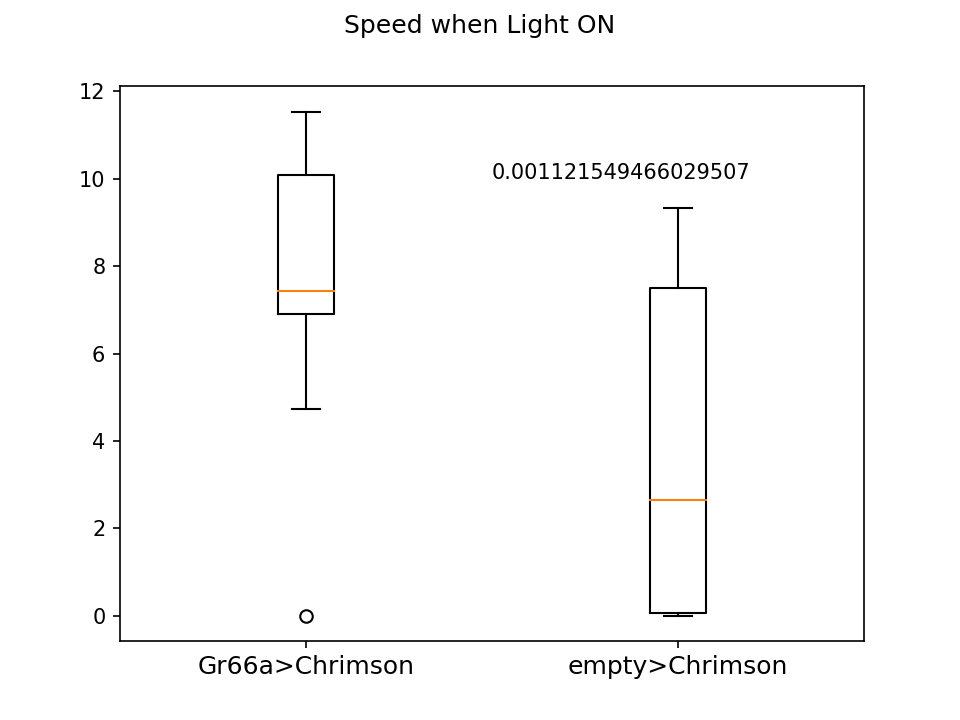

LeveneResult(statistic=12.37490361306062, pvalue=0.0009365291420544363)


Text(1.5, 10, '0.001121549466029507')

In [11]:
# compare median speed when light is ON between Gr66a and empty-Gal4
Gr66a_ON_median = []
for i in range(len(speed_Gr66a_ON)):
    Gr66a_ON_median.append(speed_Gr66a_ON[i].median())
empty_ON_median = []
for i in range(len(speed_empty_ON)):
    empty_ON_median.append(speed_empty_ON[i].median())

data = [Gr66a_ON_median, empty_ON_median]
fig=plt.figure()
ax=fig.add_subplot(111)
ax.boxplot(data)
ax.set_xticklabels(['Gr66a>Chrimson','empty>Chrimson'], fontsize=12, rotation=0)
fig.suptitle('Speed when Light ON')
#The Levene test tests the null hypothesis that all input samples are from populations with equal variances. 
print(stats.levene(Gr66a_ON_median, empty_ON_median)) 
# As Levene's test rejects the null hypothesis that the two samples have the same variance, I have to use
# a non-parametric test: The Wilcoxon Rank Sum test
ranksum_test_statistics = stats.ranksums(Gr66a_ON_median, empty_ON_median)
ax.text(1.5,10, ranksum_test_statistics[1])

<IPython.core.display.Javascript object>


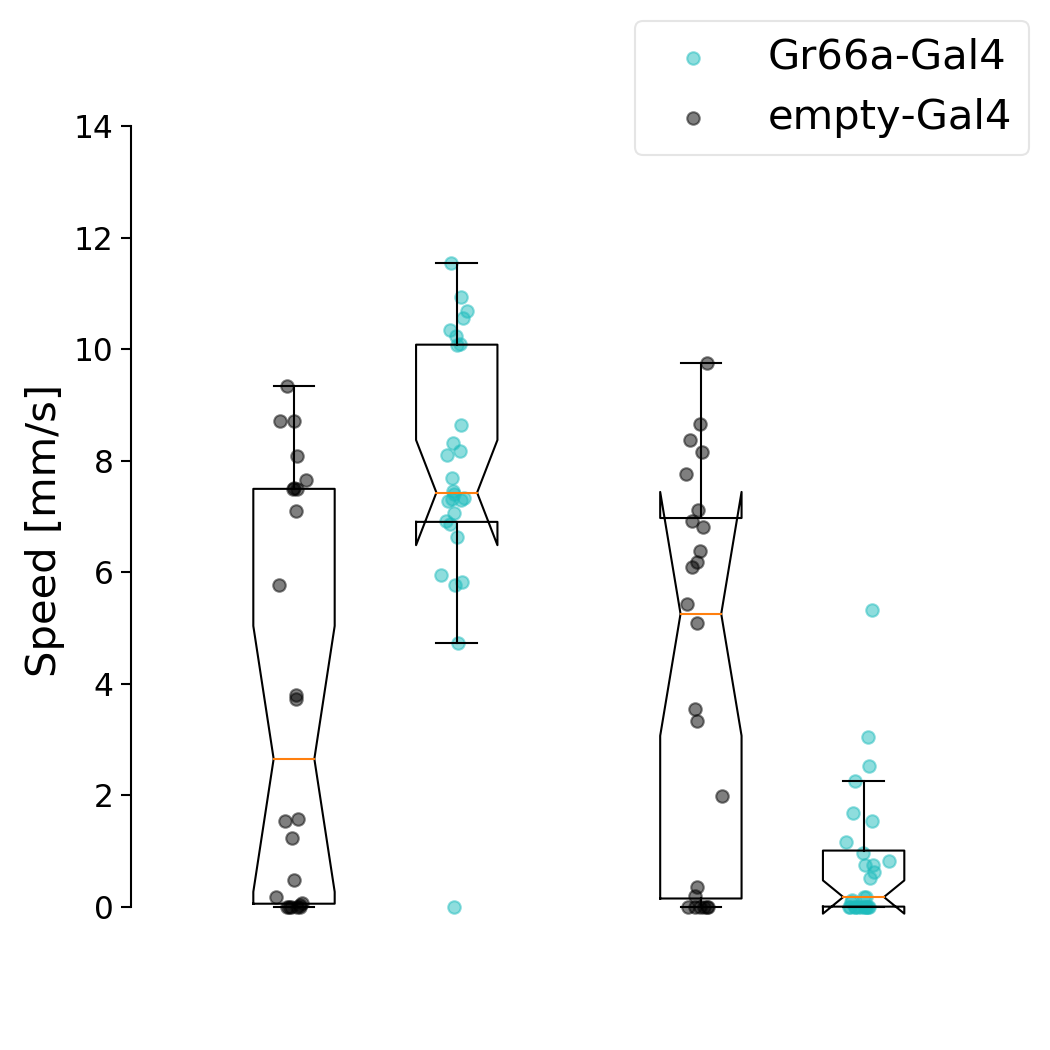

In [12]:
# one nice plot for the figure
#data = [Gr66a_ON_median, empty_ON_median, Gr66a_OFF_median,  empty_OFF_median]
data = [empty_ON_median, Gr66a_ON_median, empty_OFF_median, Gr66a_OFF_median]
positions = [1,2,3.5,4.5]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.set_rasterization_zorder(1)

ax.boxplot(data,positions=positions, showfliers=False, notch=True,zorder=1)

# plot single points for each dataset
x_empty_light_on = np.random.normal(1, 0.05, size=len(empty_ON_median))
x_gr66a_light_on = np.random.normal(2, 0.05, size=len(Gr66a_ON_median))
x_empty_light_off = np.random.normal(3.5, 0.05, size=len(empty_OFF_median))
x_gr66a_light_off = np.random.normal(4.5, 0.05, size=len(Gr66a_OFF_median))

ax.scatter(x=x_gr66a_light_on, y=Gr66a_ON_median, alpha=0.5, color='#1ebcbd', label='Gr66a-Gal4',zorder=0)
ax.scatter(x=x_gr66a_light_off, y=Gr66a_OFF_median, alpha=0.5, color='#1ebcbd',zorder=0)
ax.scatter(x=x_empty_light_on, y=empty_ON_median, alpha=0.5, color='k', label='empty-Gal4',zorder=0)
ax.scatter(x=x_empty_light_off, y=empty_OFF_median, alpha=0.5, color='k',zorder=0)

#ax.set_xticklabels(['Light On','Light Off','Light On','Light Off'], fontsize=22, rotation=60)
ax.set_xticklabels([])
ax.set_ylabel('Speed [mm/s]', fontsize=20)

ax.set_ylim(-0.5,14)
#ax.grid(alpha=0.5, axis='y')

# extend x axis to make space for legend
ax.set_xlim(0,5)

# get rid of ticks (bottom ticks)
ax.tick_params(
        #axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the left edge are off
        labelleft=True,   # labels along the left edge are off
        labelbottom=True
        ) 

# turn spines of everywhere except on the left
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(1)
# modify spines on the left
ax.spines['left'].set_bounds(-0,14)

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', width=1, length =5)
#ax.tick_params(axis='both', which='minor', width =2,length =3)
ax.tick_params(axis='y', labelsize=15)

fig.legend(fontsize=20, framealpha=0.5)
#fig.tight_layout()
#fig.savefig(Path(str(target_path), 'Fig3f.eps'), rasterized=True, dpi=300)

<IPython.core.display.Javascript object>


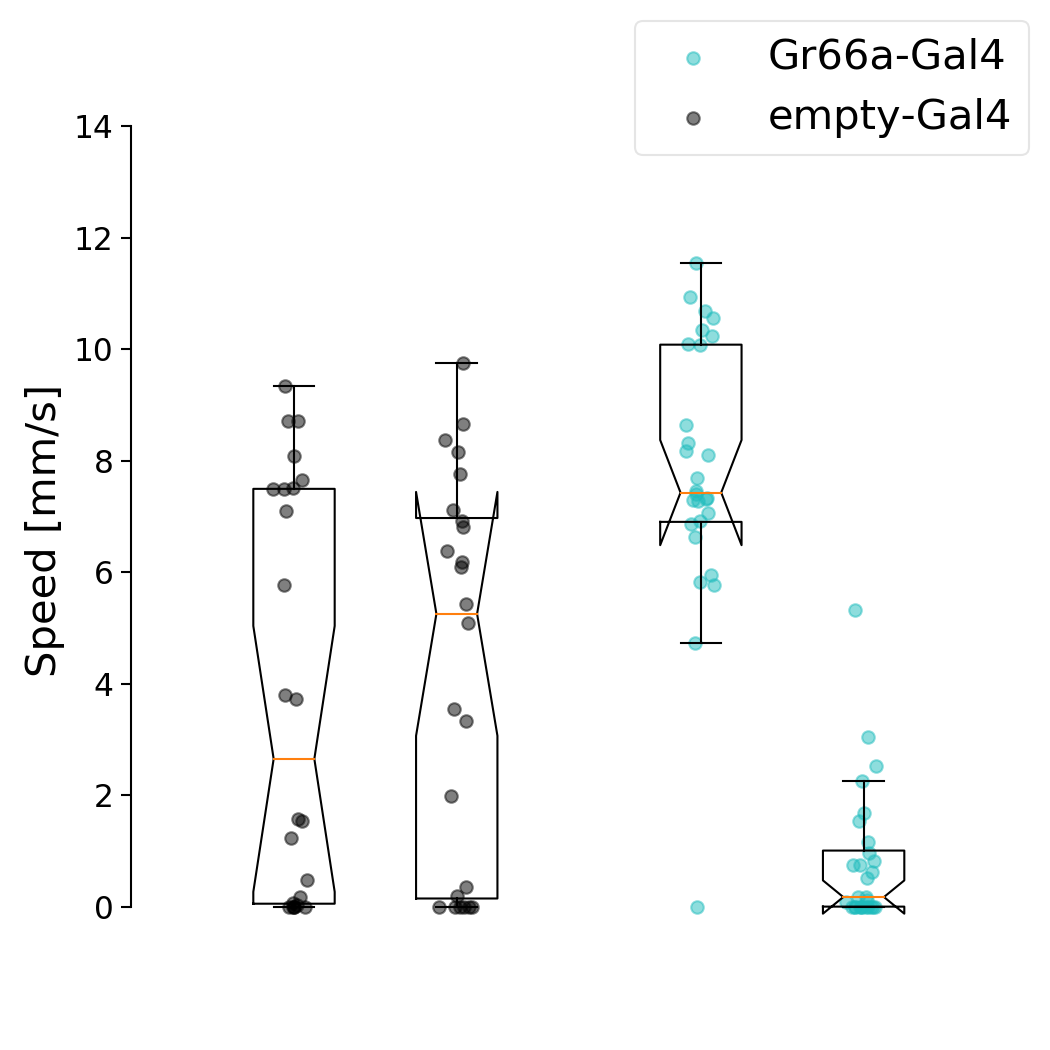

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [14]:
# Rearrangment of the plot: The two controls first (light on vs off) and then the experimental conditions.
# Done on the request of ML - I think this mask the TH message that the really cool difference we observe 
# is the significant difference compared to the control (e.g. in the light off condition) which is very
# obvious in the plot above!
#data = [Gr66a_ON_median, empty_ON_median, Gr66a_OFF_median,  empty_OFF_median]
data = [empty_ON_median, empty_OFF_median, Gr66a_ON_median,  Gr66a_OFF_median]
positions = [1,2,3.5,4.5]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.set_rasterization_zorder(1)

ax.boxplot(data,positions=positions, showfliers=False, notch=True,zorder=1)

# plot single points for each dataset
x_empty_light_on = np.random.normal(1, 0.05, size=len(empty_ON_median))
x_gr66a_light_on = np.random.normal(3.5, 0.05, size=len(Gr66a_ON_median))
x_empty_light_off = np.random.normal(2, 0.05, size=len(empty_OFF_median))
x_gr66a_light_off = np.random.normal(4.5, 0.05, size=len(Gr66a_OFF_median))

ax.scatter(x=x_gr66a_light_on, y=Gr66a_ON_median, alpha=0.5, color='#1ebcbd', label='Gr66a-Gal4',zorder=0)
ax.scatter(x=x_gr66a_light_off, y=Gr66a_OFF_median, alpha=0.5, color='#1ebcbd',zorder=0)
ax.scatter(x=x_empty_light_on, y=empty_ON_median, alpha=0.5, color='k', label='empty-Gal4',zorder=0)
ax.scatter(x=x_empty_light_off, y=empty_OFF_median, alpha=0.5, color='k',zorder=0)

#ax.set_xticklabels(['Light On','Light Off','Light On','Light Off'], fontsize=22, rotation=60)
ax.set_xticklabels([])
ax.set_ylabel('Speed [mm/s]', fontsize=20)

ax.set_ylim(-0.5,14)
#ax.grid(alpha=0.5, axis='y')

# extend x axis to make space for legend
ax.set_xlim(0,5)

# get rid of ticks (bottom ticks)
ax.tick_params(
        #axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the left edge are off
        labelleft=True,   # labels along the left edge are off
        labelbottom=True
        ) 

# turn spines of everywhere except on the left
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(1)
# modify spines on the left
ax.spines['left'].set_bounds(-0,14)

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', width=1, length =5)
#ax.tick_params(axis='both', which='minor', width =2,length =3)
ax.tick_params(axis='y', labelsize=15)

fig.legend(fontsize=20, framealpha=0.5)
#fig.tight_layout()
fig.savefig(Path(str(target_path), 'Fig3f-rearranged.eps'), rasterized=True, dpi=300)

<IPython.core.display.Javascript object>


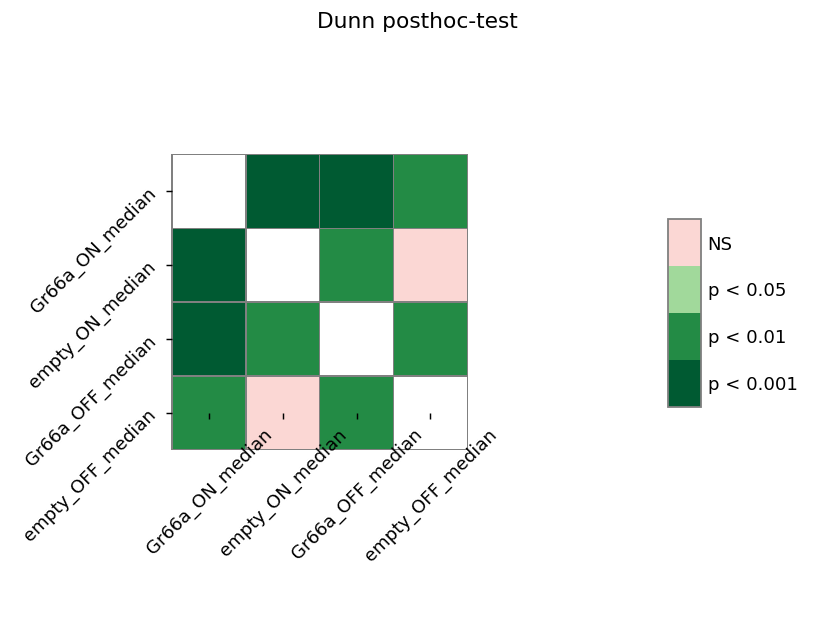

C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\ipykernel_launcher.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [51]:
# stats for the graph above!
# I didn't go for ANOVA because I'm sure we're violating its first assumption: Independence of samples! I do
# not think the four samples are equally independent from each other.
# I therefore went with the non-parametric Kruskal-Wallis test which is followed by Dunn's test. This is all
# implemented in one function in the scikit-posthoc library!
data ={
  "Gr66a_ON_median": Gr66a_ON_median,
  "empty_ON_median": empty_ON_median,
  "Gr66a_OFF_median": Gr66a_OFF_median,
  "empty_OFF_median": empty_OFF_median
}

fig=plt.figure()
# loop going through the timepointes stim zones
#for counter_stim, i_times in enumerate(times):
#    # prepare data for analysis
all_groups = np.zeros((0,2))
    # loop going through each condition (0Hz, 15Hz and genetic control!)
for counter, i_data in enumerate(data):
    current_group = np.zeros((len(data[i_data]),2))
    
    # Give a number to each condition, Must be a number unfortunately. We'll just
    # go with 0, 1, 2 and 3 in the order of the data! Check how "data" is constructed
    # above!
    current_group[:,0] = counter

    current_group[:,1] = data[i_data]
    # Data is now in format to be analyzed by posthoc_dunn function - a 2D array with first column
    # indicating the group and the second column the associated data ponits
    all_groups = np.vstack((all_groups,current_group))

ax=fig.add_subplot(121) 
#ax.set_title(i_times)

#fig.clf()
# Do with Pandas
all_median_pd = pd.DataFrame(all_groups)
all_median_pd.columns = ['groups', 'values']
# the actual test
dunn_result = sp.posthoc_dunn(all_median_pd, val_col='values',
                              group_col='groups')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5',  'clip_on':
    False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
# seems to grab the current axis (plt.gca).
sb_plot = sp.sign_plot(dunn_result, **heatmap_args)

tick_labels = []
for i in data:
    tick_labels.append(i)
ax.set_xticklabels(tick_labels, rotation = 45)
ax.set_yticklabels(tick_labels, rotation = 45)


# some info
fig.suptitle('Dunn posthoc-test')
fig.tight_layout()


$$\frac{1}{C}*\frac{\Delta C}{t}$$